In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
from __future__ import print_function
import argparse
import os

import numpy as np
import pickle

from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Flatten, Dense, Dropout
from keras.layers import merge
from keras.optimizers import Adam, SGD, RMSprop
from keras.preprocessing.image import list_pictures, array_to_img

from image_ext import list_pictures_in_multidir, load_imgs_asarray, get_center
from create_fcn import create_fcn01, create_pupil_net00
from fname_func import load_fnames, make_fnames

np.random.seed(2016)

/home/nakazawa_atsushi/anaconda3/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/nakazawa_atsushi/anaconda3/envs/py3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
#
#  MAIN STARTS FROM HERE
#
if __name__ == '__main__':
    
    target_size = (224, 224)
    dpath_this = './'
    dname_checkpoints = 'checkpoints_pupil_net00_aug2'
    dname_checkpoints_fcn01 = 'checkpoints_fcn01'
    fname_architecture = 'architecture.json'
    fname_weights = "model_weights_{epoch:02d}.h5"
    fname_stats = 'stats01.npz'
    dim_ordering = 'channels_first'
    fname_history = "history.pkl"

    # モデルを作成
    print('creating model...')
    model_pupil_net = create_pupil_net00(target_size)
    
    if os.path.exists(dname_checkpoints) == 0:
        os.mkdir(dname_checkpoints)    

creating model...


In [3]:
    # Read Learning Data
    fnames = load_fnames('data_augumented_2/list_train_01.txt')
    [fpaths_xs_train,fpaths_ys_train] = make_fnames(fnames,'data_augumented_2/img','data_augumented_2/mask','')
    #fnames = load_fnames('data/list_train_01.txt')
    #[fpaths_xs_train,fpaths_ys_train] = make_fnames(fnames,'data/img','data/mask','OperatorA_')

    X_train = load_imgs_asarray(fpaths_xs_train, grayscale=False, target_size=target_size,
                                dim_ordering=dim_ordering)
    Y_train = load_imgs_asarray(fpaths_ys_train, grayscale=True, target_size=target_size,
                                dim_ordering=dim_ordering) 

    # Read Validation Data
    fnames = load_fnames('data_augumented_2/list_valid_01.txt')
    [fpaths_xs_valid,fpaths_ys_valid] = make_fnames(fnames,'data_augumented_2/img','data_augumented_2/mask','')
    #fnames = load_fnames('data/list_valid_01.txt')
    #[fpaths_xs_valid,fpaths_ys_valid] = make_fnames(fnames,'data/img','data/mask','OperatorA_')
    
    print('reading validation data')
    X_valid = load_imgs_asarray(fpaths_xs_valid, grayscale=False, target_size=target_size,
                                dim_ordering=dim_ordering)
    Y_valid = load_imgs_asarray(fpaths_ys_valid, grayscale=True, target_size=target_size,
                                dim_ordering=dim_ordering)      

    # obtain center of pupil
    center_train = []
    center_valid = []
    
    for i in range(Y_train.shape[0]):
        center_train.append(get_center(Y_train[i,0,:,:]))

    for i in range(Y_valid.shape[0]):
        center_valid.append(get_center(Y_valid[i,0,:,:]))
    
    center_train = np.array(center_train)
    center_valid = np.array(center_valid)

    print('==> ' + str(len(X_train)) + ' training images loaded')
    print('==> ' + str(len(Y_train)) + ' training masks loaded')
    print('==> ' + str(len(X_valid)) + ' validation images loaded')
    print('==> ' + str(len(Y_valid)) + ' validation masks loaded')

    # 前処理
    print('computing mean and standard deviation...')
    mean = np.mean(X_train, axis=(0, 2, 3))
    std = np.std(X_train, axis=(0, 2, 3))
    print('==> mean: ' + str(mean))
    print('==> std : ' + str(std))

    print('saving mean and standard deviation to ' + fname_stats + '...')
    stats = {'mean': mean, 'std': std}
    if os.path.exists(dname_checkpoints) == 0:
        os.mkdir(dname_checkpoints)
    np.savez(dname_checkpoints + '/' + fname_stats, **stats)
    print('==> done')

    print('globally normalizing data...')
    for i in range(3):
        X_train[:, i] = (X_train[:, i] - mean[i]) / std[i]
        X_valid[:, i] = (X_valid[:, i] - mean[i]) / std[i]
    Y_train /= 255
    Y_valid /= 255
    print('==> done')

reading validation data
==> 13650 training images loaded
==> 13650 training masks loaded
==> 2093 validation images loaded
==> 2093 validation masks loaded
computing mean and standard deviation...
==> mean: [126.17433  90.78752  78.74256]
==> std : [61.172367 47.73529  52.325943]
saving mean and standard deviation to stats01.npz...
==> done
globally normalizing data...
==> done


In [4]:
    fcn00_initialization = 0
    
    if fcn00_initialization == 1:
        # モデルに学習済のfcn01 Weightをロードする
        epoch = 100
        fname_weights = 'model_weights_%02d.h5'%(epoch)
        model_fcn01 = create_fcn01(target_size)
        fpath_weights_fcn01 = os.path.join(dname_checkpoints_fcn01, fname_weights)
        model_fcn01.load_weights(fpath_weights_fcn01)

        # load weights from Learned U-NET
        layer_names = ['conv1_1','conv1_2','conv2_1','conv2_2']

        print('copying layer weights')
        for name in layer_names:
            print(name)
            model_pupil_net.get_layer(name).set_weights(model_fcn01.get_layer(name).get_weights())
            model_pupil_net.get_layer(name).trainable = True

In [5]:
    # 損失関数，最適化手法を定義
    adam = Adam(lr=1e-5)
    model_pupil_net.compile(optimizer=adam, loss='mean_squared_error')

    # 構造・重みを保存するディレクトリーの有無を確認
    dpath_checkpoints = os.path.join(dpath_this, dname_checkpoints)
    if not os.path.isdir(dpath_checkpoints):
        os.mkdir(dpath_checkpoints)

    # 重みを保存するためのオブジェクトを用意
    fname_weights = "model_weights_{epoch:02d}.h5"
    fpath_weights = os.path.join(dpath_checkpoints, fname_weights)
    checkpointer = ModelCheckpoint(filepath=fpath_weights, save_best_only=False)

In [6]:
    # トレーニングを開始
    print('start training...')
    history = model_pupil_net.fit(X_train, center_train, batch_size=32, epochs=200, verbose=1,
                  shuffle=True, validation_data=(X_valid, center_valid), callbacks=[checkpointer])

start training...
Train on 13650 samples, validate on 2093 samples
Epoch 1/200
13650/13650 [==============================] - 216s 16ms/step - loss: 1263.1669 - val_loss: 272.0286
Epoch 2/200
13650/13650 [==============================] - 205s 15ms/step - loss: 153.5529 - val_loss: 104.0343
Epoch 3/200
13650/13650 [==============================] - 205s 15ms/step - loss: 85.9401 - val_loss: 76.9356
Epoch 4/200
13650/13650 [==============================] - 205s 15ms/step - loss: 66.9570 - val_loss: 63.3830
Epoch 5/200
13650/13650 [==============================] - 205s 15ms/step - loss: 58.3836 - val_loss: 48.9919
Epoch 6/200
13650/13650 [==============================] - 205s 15ms/step - loss: 52.4874 - val_loss: 45.8828
Epoch 7/200
13650/13650 [==============================] - 205s 15ms/step - loss: 48.4424 - val_loss: 51.1767
Epoch 8/200
13650/13650 [==============================] - 204s 15ms/step - loss: 43.9702 - val_loss: 38.3990
Epoch 9/200
13650/13650 [=======================

Epoch 75/200
13650/13650 [==============================] - 206s 15ms/step - loss: 1.9277 - val_loss: 7.2268
Epoch 76/200
13650/13650 [==============================] - 206s 15ms/step - loss: 1.9455 - val_loss: 7.4519
Epoch 77/200
13650/13650 [==============================] - 206s 15ms/step - loss: 2.0708 - val_loss: 8.1272
Epoch 78/200
13650/13650 [==============================] - 205s 15ms/step - loss: 1.9640 - val_loss: 7.8919
Epoch 79/200
13650/13650 [==============================] - 205s 15ms/step - loss: 1.8975 - val_loss: 7.8647
Epoch 80/200
13650/13650 [==============================] - 205s 15ms/step - loss: 1.8003 - val_loss: 7.5588
Epoch 81/200
13650/13650 [==============================] - 205s 15ms/step - loss: 1.7743 - val_loss: 7.2807
Epoch 82/200
13650/13650 [==============================] - 205s 15ms/step - loss: 1.7423 - val_loss: 7.4877
Epoch 83/200
13650/13650 [==============================] - 205s 15ms/step - loss: 1.6939 - val_loss: 7.1097
Epoch 84/200
13650/

13650/13650 [==============================] - 206s 15ms/step - loss: 0.6210 - val_loss: 6.4085
Epoch 150/200
13650/13650 [==============================] - 206s 15ms/step - loss: 0.5864 - val_loss: 6.6933
Epoch 151/200
13650/13650 [==============================] - 206s 15ms/step - loss: 0.6131 - val_loss: 6.6108
Epoch 152/200
13650/13650 [==============================] - 206s 15ms/step - loss: 0.6968 - val_loss: 6.5311
Epoch 153/200
13650/13650 [==============================] - 206s 15ms/step - loss: 0.5667 - val_loss: 6.4936
Epoch 154/200
13650/13650 [==============================] - 206s 15ms/step - loss: 0.6151 - val_loss: 6.4650
Epoch 155/200
13650/13650 [==============================] - 206s 15ms/step - loss: 0.6116 - val_loss: 6.3126
Epoch 156/200
13650/13650 [==============================] - 206s 15ms/step - loss: 0.5602 - val_loss: 6.9023
Epoch 157/200
13650/13650 [==============================] - 206s 15ms/step - loss: 0.5929 - val_loss: 6.4888
Epoch 158/200
13650/1365

In [7]:
    # Save History
    f = open(dname_checkpoints + '/' + fname_history,'wb')
    pickle.dump(history.history,f)
    f.close

<function BufferedWriter.close>

checkpoints_pupil_net00_aug2/history.pkl


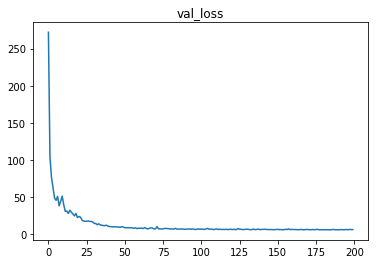

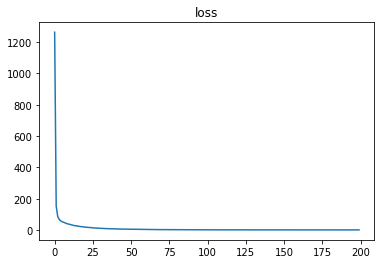

In [9]:
    #
    #   Show History
    #
    
    # load pickle
    print(dname_checkpoints + '/' + fname_history)
    history = pickle.load(open(dname_checkpoints + '/' + fname_history, 'rb'))
    
    from PIL import Image
    import matplotlib.pyplot as plt    
    
    for k in history.keys():
        plt.plot(history[k])
        plt.title(k)
        plt.show()